# Part 1: Transformer Language Model

A transformer language model is a type of neural network architecture used for natural language processing tasks such as language translation and text generation. It uses self-attention mechanisms to capture dependencies between different parts of the input text, allowing it to better understand context and produce more accurate outputs. Transformer language models have achieved state-of-the-art performance on many language-related tasks, including language modeling and machine translation.

For more information: https://arxiv.org/pdf/1706.03762.pdf

__Tasks:__ 

1. How does the Transformer function?
2. Understand the differnece between query, key and value vectors.
3. Understanding the positional encoding scheme that enables the model to distinguish between elements in the input sequence, despite the absence of explicit ordering information.
4. Have the abality of "code navigation"/"code exploration", to have the skill of being able to quickly jump between different parts of a codebase to understand how different functions and classes interact with each other.

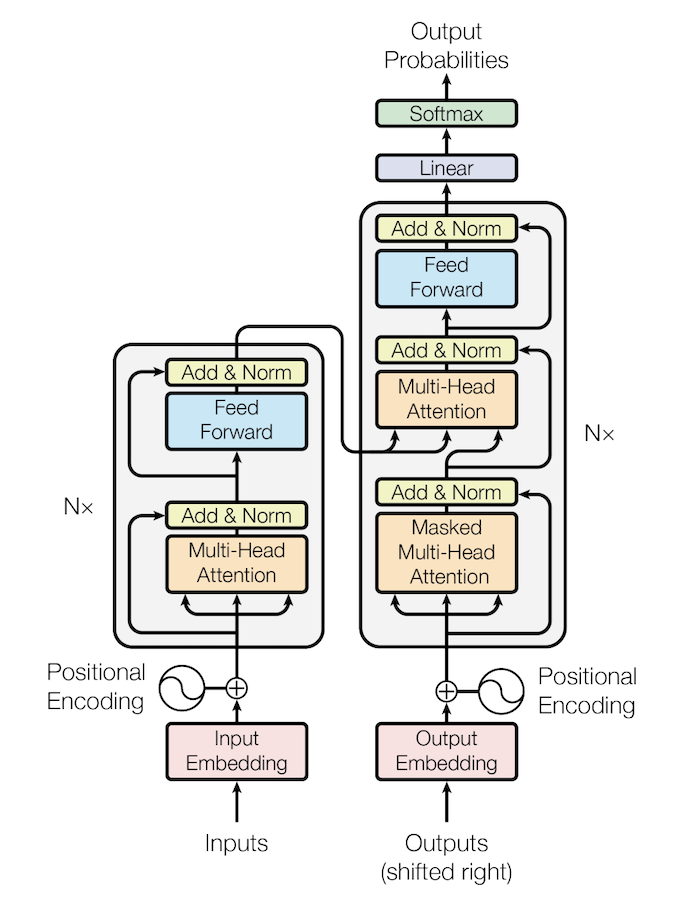

In [115]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.utils import download_url
import io
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [116]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
## Basically, the model can be divided into three parts:
## Encoding layer, Decoding layer and Output layer
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().to(device) #See below
        self.decoder = Decoder().to(device) #See below

        ## The output d_model is the dimension of each token output in the decoding layer
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False) ##
    def forward(self, enc_inputs, dec_inputs): # encoder / decoder 

        enc_outputs, enc_self_attns = self.encoder(enc_inputs)

        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)

        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns

#  Question
  
 1. What is the function of enc_self_attns (one of the output of encoder)? 

 2. What are the inputs of the decoder? Why does the decoder require two outputs?

Answer:

In [117]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model).to(device)  ## size -->  src_vocab_size * d_model
        self.pos_emb = PositionalEncoding(d_model).to(device) ## see the details in 'attention is all you need'
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs --> [batch_size x source_len]

        ## enc_outputs --> [batch_size, src_len, d_model]
        enc_outputs = self.src_emb(enc_inputs)

        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)

        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [118]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) # pe --> [max_len*d_model]

        pe = pe.unsqueeze(0).transpose(0, 1) # pe --> [max_len*1*d_model]

        self.register_buffer('pe', pe) 

    def forward(self, x): # x --> [seq_len, batch_size, d_model]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x.to(device))

In [119]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k, one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

#  Question
  
 1. Why do we need positional encoding?

 2. What does get_attn_pad_mask do? 

Answer:

In [120]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention().to(device)
        self.pos_ffn = PoswiseFeedForwardNet().to(device)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) 
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs --> [batch_size x len_q x d_model]
        return enc_outputs, attn

In [121]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        ## The inputs size of QKV vectors are the same
        self.W_Q = nn.Linear(d_model, d_k * n_heads).to(device)
        self.W_K = nn.Linear(d_model, d_k * n_heads).to(device)
        self.W_V = nn.Linear(d_model, d_v * n_heads).to(device)
        self.linear = nn.Linear(n_heads * d_v, d_model).to(device)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):

        ## Q --> [batch_size x len_q x d_model], K: [batch_size x len_k x d_model], V: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)

        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s --> [batch_size x n_heads x len_q x d_k]
        
        # YOUR CODE 
        raise NotImplementedError()

        ## input attn_mask --> batch_size x len_q x len_k
        ## new attn_mask --> [batch_size x n_heads x len_q x len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)

        ## context --> [batch_size x n_heads x len_q x d_v]
        ## attn --> [batch_size x n_heads x len_q x len_k]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context --> [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output --> [batch_size x len_q x d_model]

#Calculate the Attention Scores
We'll now try to calculate the attention scores between a set of query vectors ($Q$) and a set of key vectors ($K$), given a set of value vectors ($V$). The attention scores indicate the importance of each key vector to each query vector, and are calculated by taking the dot product of the query and key vectors, scaled by the square root of the dimensionality of the key vectors.

\begin{equation}
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
\end{equation}

Where $Q$, $K$, and $V$ are the query, key, and value matrices, respectively, and $d_k$ is the dimensionality of the key vectors. The function first calculates the dot product of $Q$ and $K$ transpose, scaled by the square root of $d_k$. It then applies the softmax function to the resulting attention scores to obtain a probability distribution over the key vectors. Finally, the function multiplies each value vector by its corresponding attention score and sums the results to obtain the output of the attention mechanism.

It might be helpful to keep in mind that matrix K need to be transposed.

In [122]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        """Q --> [batch_size x n_heads x len_q x d_k]
          K --> [batch_size x n_heads x len_k x d_k]
          V --> [batch_size x n_heads x len_k x d_v]
          scores --> [batch_size x n_heads x len_q x len_k]"""

        # YOUR CODE 
        raise NotImplementedError()

        scores.masked_fill_(attn_mask, -1e9) # This line applies a mask attn_mask to the attention scores scores by replacing the masked positions with a large negative number -1e9. 
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # calculates the weighted sum of the values V, using the attention probabilities attn as the weights.
        return context, attn

# Question

  What does scores.masked_fill_(attn_mask, -1e9) do?

Answer:

In [123]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs --> [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

In [124]:
def get_attn_subsequent_mask(seq): # seq --> [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)] # attn_shape --> [batch_size, tgt_len, tgt_len]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask  # [batch_size, tgt_len, tgt_len]

In [125]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model).to(device)
        self.pos_emb = PositionalEncoding(d_model).to(device)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs --> [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs)  # [batch_size, tgt_len, d_model]
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, tgt_len, d_model]

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).to(device)

        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs).to(device)

        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [126]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention().to(device)
        self.dec_enc_attn = MultiHeadAttention().to(device)
        self.pos_ffn = PoswiseFeedForwardNet().to(device)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

In [127]:
## Let's train a model for translation from Norwaygian to English

def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)


sentences = ['jeg elsker dyp læring P', 'S i love deep learning', 'i love deep learning E']


# Transformer Parameters
## word list
src_vocab = {'P': 0, 'jeg': 1, 'elsker': 2, 'dyp': 3, 'læring': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'love': 2, 'deep': 3, 'learning': 4, 'S': 5, 'E': 6}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # length of source
tgt_len = 5 # length of target

## hyper-parameters
d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

model = Transformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

enc_inputs, dec_inputs, target_batch = make_batch(sentences)

for epoch in range(20):
    optimizer.zero_grad()
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs.to(device), dec_inputs.to(device))
    loss = criterion(outputs.view(-1, outputs.size(-1)).to(device), target_batch.contiguous().view(-1).to(device))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 0001 cost = 1.995974
Epoch: 0002 cost = 1.699031
Epoch: 0003 cost = 0.548466
Epoch: 0004 cost = 0.592112
Epoch: 0005 cost = 0.163137
Epoch: 0006 cost = 0.030806
Epoch: 0007 cost = 0.012860
Epoch: 0008 cost = 0.012712
Epoch: 0009 cost = 0.012706
Epoch: 0010 cost = 0.011417
Epoch: 0011 cost = 0.007169
Epoch: 0012 cost = 0.004542
Epoch: 0013 cost = 0.002712
Epoch: 0014 cost = 0.002672
Epoch: 0015 cost = 0.002121
Epoch: 0016 cost = 0.001615
Epoch: 0017 cost = 0.001155
Epoch: 0018 cost = 0.001031
Epoch: 0019 cost = 0.000825
Epoch: 0020 cost = 0.000932


In [128]:
# Now let's see the outputs
model.eval()
outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs.to(device), dec_inputs.to(device))
result_index = torch.max(outputs.view(-1, outputs.size(-1)), 1)  
print(result_index.indices)

tensor([1, 2, 3, 4, 6], device='cuda:0')


It is expected to get 'tensor([1, 2, 3, 4, 6])' 

# Question

1. What is the meaning of '[1, 2, 3, 4, 6]'?

2. Can you train the model to translate another language? 

In [129]:
## hyper-parameters
epoch = 1
batch_size = 16
learning_rate = 0.0001
d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention
src_vocab_size = 100 # length of source
tgt_vocab_size = 100 # length of target

In [130]:
class CodeDataset(Dataset):
    def __init__(self):
        download_url('https://github.com/ecs-vlc/COMP6248/raw/master/exercises/lab7/dataset.txt', '.', 'dataset.txt', None)
        with io.open('dataset.txt', 'r') as f:
            self.data = f.readlines()

        self.PAD='_'
        self.SOS='^'
        self.EOS='$'
        self.PAD_IDX=0

        # construct the vocabularies to numericalise the data
        self.alphabet = "*".join(self.PAD+self.SOS+self.EOS+"abcdefghijklmnopqrstuvwxyz ").split('*')

        self.alphabet_indices = dict((c, i) for i, c in enumerate(self.alphabet))
        self.indices_alphabet = dict((i, c) for i, c in enumerate(self.alphabet))

        self.morsebet = self.PAD+self.SOS+self.EOS+'.- /'             ##### '_^$.- /'
        self.morse_indices = dict((c, i) for i, c in enumerate(self.morsebet))
        self.indices_morse = dict((i, c) for i, c in enumerate(self.morsebet))

    def encode_alpha(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.alphabet_indices[char]

        return x

    def decode_alpha(self, ten, skip_tok=False):
        s = ''
        ten = ten.view(-1)
        for v in ten.view(-1):
            if not skip_tok:
                s += self.indices_alphabet[v.item()]
            elif v>2:
                s += self.indices_alphabet[v.item()]
        return s

    def encode_morse(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.morse_indices[char]

        return x

    def decode_morse(self, ten):
        s = ''
        for v in ten:
          s += self.indices_morse[v]
        return s

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i, max_len_input=30, max_len_label=30):
        inp, out = self.data[i].strip().split('|')
        x = self.encode_morse(inp)
        y = self.encode_alpha(out[::-1])

        if max_len_input and max_len_label is not None:
            x_len = min(len(x), max_len_input)
            y_len = min(len(y), max_len_label)

            # Pad the input sequence with the PAD character
            x_padded = F.pad(x[:x_len], (0, max_len_input - x_len), value=self.morse_indices[self.PAD])

            # Pad the output sequence with the PAD character
            y_padded = F.pad(y[:y_len], (0, max_len_label - y_len), value=self.alphabet_indices[self.PAD])

            return x_padded, y_padded

        return x, y

In [131]:
# This will be used to automatically pad all batch items to the same length
def pad_collate(batch):
    data = [item[0] for item in batch]
    data = pad_sequence(data)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets)
    return [data, targets]

# Load the data and split randomly into training and val subsets
ds = CodeDataset()
tr, va = random_split(ds, [len(ds) - len(ds)//3, len(ds)//3])
trainloader = DataLoader(tr, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
valloader = DataLoader(va, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

Using downloaded and verified file: ./dataset.txt


In [132]:
model = Transformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(epoch):
    for i, batch in enumerate(trainloader):
        src, tgt = batch
        dec_input = tgt[1:-1, :].to(device)
        target = tgt[1:-1, :].to(device) # Remove first token from target sequence
        logits, _, _, _ = model(src[2:, :].to(device), dec_input)
        loss = nn.CrossEntropyLoss()(logits.permute(1, 2, 0), target.permute(1, 0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

'''
save the tarined model
'''
# torch.save(model.state_dict(),'TLM_Morce.pth')
# print('saved the model!')

Epoch: 0, Batch: 0, Loss: 4.177205562591553
Epoch: 0, Batch: 100, Loss: 0.0018332947511225939
Epoch: 0, Batch: 200, Loss: 0.0006798889371566474
Epoch: 0, Batch: 300, Loss: 0.0005041661788709462
Epoch: 0, Batch: 400, Loss: 0.001203641528263688
Epoch: 0, Batch: 500, Loss: 0.0003916809509973973
Epoch: 0, Batch: 600, Loss: 0.0002636357967276126
Epoch: 0, Batch: 700, Loss: 0.0002729090047068894
Epoch: 0, Batch: 800, Loss: 0.00022791542869526893
Epoch: 0, Batch: 900, Loss: 0.00018758015357889235
Epoch: 0, Batch: 1000, Loss: 0.00016914539446588606
Epoch: 0, Batch: 1100, Loss: 0.00015308965521398932
Epoch: 0, Batch: 1200, Loss: 0.00015531678218394518
Epoch: 0, Batch: 1300, Loss: 0.0001221343845827505
Epoch: 0, Batch: 1400, Loss: 0.00011525541776791215
Epoch: 0, Batch: 1500, Loss: 0.00010473492875462398
Epoch: 0, Batch: 1600, Loss: 9.959033195627853e-05
Epoch: 0, Batch: 1700, Loss: 9.312365727964789e-05
Epoch: 0, Batch: 1800, Loss: 8.32161313155666e-05
Epoch: 0, Batch: 1900, Loss: 8.92658717930

'\nsave the tarined model\n'

In [133]:
# construct the vocabularies
PAD='_'
SOS='^'
EOS='$'
alphabet = "*".join(PAD+SOS+EOS+"abcdefghijklmnopqrstuvwxyz ").split('*')
indices_alphabet = dict((i, c) for i, c in enumerate(alphabet))

with torch.no_grad():
    model.eval()
    for i, batch in enumerate(valloader):
        src, tgt = batch
        dec_input = tgt[1:-1, :].to(device) # Remove last token from target sequence
        logits, _, _, _ = model(src[2:, :].to(device), dec_input)
        result_index = torch.max(logits.permute(1, 0, 2), 2).indices.tolist()

        '''
        Print and check the results 
        '''
        result_batch = []
        for batch in result_index:
            result = []
            for indice in batch:
                result.append(indices_alphabet[indice])
            result = list(filter(('_').__ne__, result))
            result.reverse()
            result_batch.append(result)
        print(result_batch)

## Questions

Do you notice that the model's output is reversed? Do you know why it's happening? Also, can you help us make it better?

By the way, the output of the model is always a sentence of a particular length. But, what if we want the model to generate sentences of varying lengths? Think about how we can change the code to achieve this, maybe by using an 'EOS' token.

Reference
https://github.com/graykode/nlp-tutorial/tree/master/5-1.Transformer